Enfoque del dataset de noticias falsas basado en CNN

In [1]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install textaugment
from textaugment import EDA

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15721 sha256=d074781eb0eef5b5909b3b12ece970d09ff14d126e7b0244ede68ec73f1f9381
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Cargar Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/TFM/Data/HuHu/"

Mounted at /content/drive


In [3]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore')
df = df[['tweet', 'mean_prejudice']]
df = df.rename(columns={"tweet": "Text", "mean_prejudice": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 1869
Tamaño conjunto de Validación: 272
Tamaño conjunto de Evaluación: 530


# Preprocesamiento y Limpieza

In [4]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("spanish")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 2 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial
    min_length = 2
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=""
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens = filtered_tokens + str(token) + " "

    if filtered_tokens == "":
        return "nada"
    else:
        return filtered_tokens

for index in X_train.index:
    X_train[index] = clean_text(X_train[index])

# Data Augmentation

In [5]:
t = EDA()

for i in range(2136):
    text = str(X_train[i])

    #new_text = t.synonym_replacement(text)
    #X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    #y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)

    new_text = t.random_swap(text)
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)

    new_text = t.random_deletion(text, p=0.2)
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))

<ipython-input-5-a15fa7a57bff>:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
<ipython-input-5-a15fa7a57bff>:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
<ipython-input-5-a15fa7a57bff>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
<ipython-input-5-a15fa7a57bff>:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)


Tamaño conjunto de Entrenamiento: 6141


# Label Encoding

No es necesario hacer Label Encoding en tareas de regresión

# Tokenización

In [6]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 5840


In [7]:
MAX_LEN = 55

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# CNN

In [8]:
EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])
model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 200)           1168000   
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             6

Training:

In [9]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16

# training
history=model.fit(encoded_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val), callbacks=[earlyStopping])


Epoch 1/20
384/384 [==============================] - 33s 47ms/step - loss: 0.7316 - mae: 0.6610 - mse: 0.7316 - val_loss: 0.9960 - val_mae: 0.7978 - val_mse: 0.9960
Epoch 2/20
384/384 [==============================] - 3s 9ms/step - loss: 0.4098 - mae: 0.4862 - mse: 0.4098 - val_loss: 0.9424 - val_mae: 0.7866 - val_mse: 0.9424
Epoch 3/20
384/384 [==============================] - 4s 10ms/step - loss: 0.3274 - mae: 0.4245 - mse: 0.3274 - val_loss: 1.3375 - val_mae: 0.9626 - val_mse: 1.3375
Epoch 4/20
384/384 [==============================] - 3s 7ms/step - loss: 0.2819 - mae: 0.3849 - mse: 0.2819 - val_loss: 1.1436 - val_mae: 0.8816 - val_mse: 1.1436
Epoch 5/20
384/384 [==============================] - 3s 8ms/step - loss: 0.2503 - mae: 0.3514 - mse: 0.2503 - val_loss: 1.1406 - val_mae: 0.8822 - val_mse: 1.1406


Curvas de Aprendizaje:

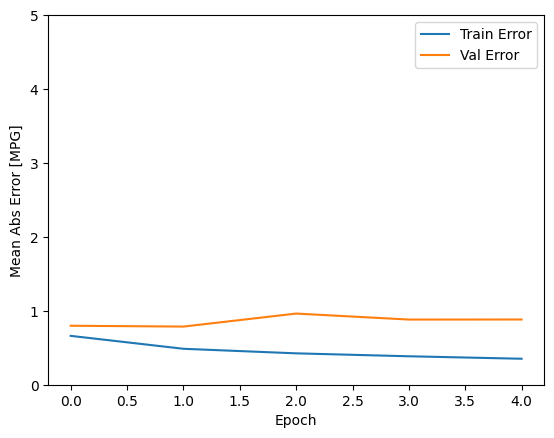

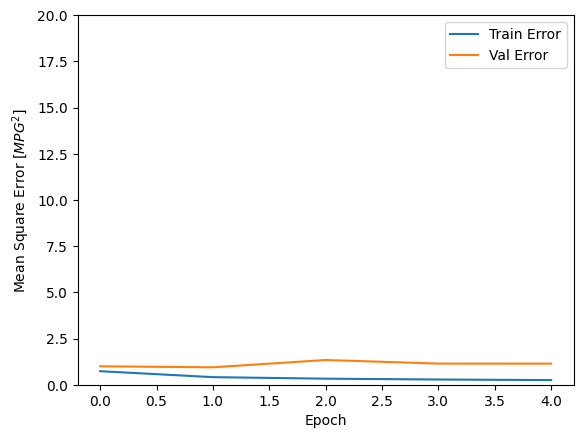

In [10]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Evaluación:

In [11]:
#X_test = np.array(X_test)
#https://www.tensorflow.org/tutorials/keras/regression?hl=es-419
loss, mae, mse = model.evaluate(encoded_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

17/17 - 0s - loss: 1.3849 - mae: 0.9638 - mse: 1.3849 - 459ms/epoch - 27ms/step
Testing set Mean Abs Error:  0.96 MPG
